## **League of Legends Tier Analysis**

**By Jonathan Wang**

## **Overview**

League of Legends is one of the world's most popular games, with over 80 million unique monthly players. Released in 2009 by Riot Games, it allows 10 players to compete in 5v5 strategic battle with a plethora of iconic characters, strategies, and maps.

League of Legends takes place on the symmetrical map Summoner's Rift, where two teams aim to destroy the opposing team's Nexus, or base. The map features a vast jungle and three "lanes", where players meet their opposing counterparts and kill their minions for gold, defeat their champions (characters), and destroy their Towers, which defend the Nexus. Each of the lanes features a specific role, ranging from durable fighters, assassins, and supporting healers.

In this analysis, we will focus on one simple question: what factors make a player successful in League of Legends? We will accomplish this by analyzing both team statistics and the individual statistics of one specific role: the Jungler. The Jungler does not occupy any of the three aforementioned lanes, instead opting to slay the monsters that occupy the map's jungle to gain experience, roam around the map securing objectives, and ambushing unsuspecting enemies in their lanes to aid his teammates.

A superior Jungler knows the most efficient path to take to kill monsters in the Jungle, applies suffocating pressure across the map by constantly ambushing enemies, and proactively secures important objectives such as Towers and Epic Monsters, which grant team-wide Gold and benefits. Because of this, Junglers have an enormous impact upon games, being able to single-handedly influence a game's outcome, making them a great role to analyze.

League of Legends features a ranking system very similar to Chess ELO, with different Tiers representing skill. In this analysis, we will use the Riot Games API, Python, Pandas, and Matplotlib to look at Junglers from two different tiers to analyze what makes a Jungler successful. We will focus on several different aspects: Gold, First Objectives, Turret Damage, Epic Monster Damage, and KDA. No need to worry, these terms will be fully explained as we move on.

## **Introduction**

We begin by importing the Riot Games API through open source library Cassiopeia and setting the developer key and region. Pandas and Matplotlib are also imported. To install Cassiopeia, type **pip install cassiopeia** into the Terminal.

In [1]:
import cassiopeia as cass # Open source library Cassiopeia
import pandas as pd # Pandas, for data manipulation
import matplotlib.pyplot as plt # MatPlotLib for visualization
%matplotlib inline
import random # Random for pulling random matches
from IPython.display import display, HTML # For displaying DataFrames neatly
key = "RGAPI-bdff8036-917d-46bc-8979-9baf4d12b52c" # My personal developer key
cass.set_riot_api_key(key)
cass.set_default_region("NA")

## **Functions for Scraping Statistics**

Riot Games recently removed the ability to access overall statistics by player through their API. Fortunately, we can still access this data across many games with a little bit of data manipulation and cleaning!

The below functions serve to scrape data from players' match histories and compile them into useful, meaningful DataFrames.

Functions **individualStats** and **isJungler** pull the statistics of the 10 individual players in a given match and identifies whether a player is the Jungler, respectively.

In [2]:
# Determines if the player is Jungler by checking for the mandatory spell "Smite".

def isJungler(participant):
    if participant.summoner_spell_d.name == "Smite" or participant.summoner_spell_f.name == "Smite":
        return True
    else:
        return False

In [3]:
# Pull the players, champions, and roles from a specific game
def individualStats(participants):
    # Dictionary and DataFrame for later use
    data = {'Player':[], 'Champion':[], 'Jungler':[], 'Kills':[], 'Deaths':[],
           'Assists':[], 'KDA':[], 'Towers Destroyed':[], 'Damage to Objectives':[], 'Team':[]}
    
    # Read in the participants
    
    for participant in participants:
        data['Player'].append(participant.summoner.name)
        data['Champion'].append(participant.champion.name)
        data['Jungler'].append(isJungler(participant))
        data['Kills'].append(participant.stats.kills)
        data['Deaths'].append(participant.stats.deaths)
        data['Assists'].append(participant.stats.assists)
        data['KDA'].append(participant.stats.kda)
        data['Towers Destroyed'].append(participant.stats.turret_kills)
        data['Damage to Objectives'].append(participant.stats.damage_dealt_to_objectives)
        data['Team'].append(participant.team.side.name)
 
        
    # Set to DataFrame, index, rearrange columns
    allStats = pd.DataFrame(data)
    allStats = allStats.set_index('Player')
    allStats = allStats[['Champion', 'Jungler', 'Kills', 'Deaths', 'Assists', 'KDA', 'Towers Destroyed', 'Damage to Objectives', 'Team']]
    
    return allStats

**firstObjectiveStats** finds the correlation between victory and taking an objective first.

In [4]:
# Scrape statistics from a match

def firstObjectiveStats(match, turretVictory, dragonVictory, baronVictory):
    if match.blue_team.first_tower:
        turretVictory['First Turret Taken'].append(True)
        turretVictory['Victory'].append(match.blue_team.win)
    elif match.red_team.first_tower:
        turretVictory['First Turret Taken'].append(True)
        turretVictory['Victory'].append(match.red_team.win)
    else: # If turret isn't taken
        turretVictory['First Turret Taken'].append(False)
        turretVictory['Victory'].append('N/A')
        
    if match.blue_team.first_dragon:
        dragonVictory['First Dragon Taken'].append(True)
        dragonVictory['Victory'].append(match.blue_team.win)
    elif match.red_team.first_dragon:
        dragonVictory['First Dragon Taken'].append(True)
        dragonVictory['Victory'].append(match.red_team.win)
    else: # If Dragon isn't taken
        dragonVictory['First Dragon Taken'].append(False)
        dragonVictory['Victory'].append('N/A')
        
    if match.blue_team.first_baron:
        baronVictory['First Baron Taken'].append(True)
        baronVictory['Victory'].append(match.blue_team.win)
    elif match.red_team.first_baron:
        baronVictory['First Baron Taken'].append(True)
        baronVictory['Victory'].append(match.red_team.win)
    else: # First Baron isn't tkaen
        baronVictory['First Baron Taken'].append(False)
        baronVictory['Victory'].append('N/A')

**individualWinStats** finds the correlation between victory and individual statistics such as KDA.

In [5]:
# Scrape individual statistics for each Jungler

def individualWinStats(match, kdaVictory, kdaLoss, objectiveDamageVictory, objectiveDamageLoss, turretDamageVictory, turretDamageLoss, goldVictory, goldLoss):
    for participant in match.participants:
        if isJungler(participant) and participant.stats.win:
            kdaVictory['KDA'].append(participant.stats.kda)
            kdaVictory['Victory'].append(participant.stats.win)
            
            turretDamageVictory['Damage to Turrets'].append(participant.stats.damage_dealt_to_turrets)
            turretDamageVictory['Victory'].append(participant.stats.win)
            
            objectiveDamageVictory['Damage to Objectives'].append(participant.stats.damage_dealt_to_objectives)
            objectiveDamageVictory['Victory'].append(participant.stats.win)
            
            goldVictory['Gold Earned'].append(participant.stats.gold_earned)
            goldVictory['Victory'].append(participant.stats.win)
        elif isJungler(participant) and not participant.stats.win:
            kdaLoss['KDA'].append(participant.stats.kda)
            kdaLoss['Victory'].append(participant.stats.win)
            
            turretDamageLoss['Damage to Turrets'].append(participant.stats.damage_dealt_to_turrets)
            turretDamageLoss['Victory'].append(participant.stats.win)
            
            objectiveDamageLoss['Damage to Objectives'].append(participant.stats.damage_dealt_to_objectives)
            objectiveDamageLoss['Victory'].append(participant.stats.win)
            
            goldLoss['Gold Earned'].append(participant.stats.gold_earned)
            goldLoss['Victory'].append(participant.stats.win)

Let's now use these functions to begin pulling data from players across different Tiers!

## **1) Challenger Tier**

The Challenger Tier is composed of League of Legends' top 0.02% players. There is only room for 200 players at once in Challenger, making it the most competitive Tier; these players are extremely skilled and are often either professionals or on the brink of playing the game professionally.

The Riot API conveniently includes access to the Challenger Tier. We begin by analyzing matches from players in this Tier. Below, we will get the Challenger Tier, iterate through the first 30 players (for the sake of statistical accuracy), and scrape important statistics, placing them into dictionaries.


In [6]:
print("CHALLENGER TIER")

challenger_players = cass.get_challenger_league(queue=cass.Queue.ranked_solo_fives)
challenger_players = [player.summoner for player in challenger_players]

# Dictionaries. These will be used for storing data.

turretVictory = {'First Turret Taken':[],'Victory':[]}
dragonVictory = {'First Dragon Taken':[],'Victory':[]}
baronVictory = {'First Baron Taken':[],'Victory':[]}

kdaVictory = {"KDA":[],'Victory':[]}
kdaLoss = {"KDA":[],'Victory':[]}

goldVictory = {"Gold Earned":[],"Victory":[]}
goldLoss = {"Gold Earned":[],"Victory":[]}

turretDamageVictory = {'Damage to Turrets':[], 'Victory':[]}
turretDamageLoss = {'Damage to Turrets':[], 'Victory':[]}

objectiveDamageVictory = {'Damage to Objectives':[], 'Victory':[]}
objectiveDamageLoss = {'Damage to Objectives':[], 'Victory':[]}

# Iterate through the Challenger League

count = 1
for player in range(0, 35):
    currentMatch = challenger_players[player].match_history[random.randint(0, 10)] # Pull random match from the top 30 players
    if currentMatch.mode.name == 'classic':    # Only look at ranked, classic games
        print("Rank", count, "Challenger player is", challenger_players[player].name)
        if count == 1: # Display the first match
            display(individualStats(currentMatch.participants))
        firstObjectiveStats(currentMatch, turretVictory, dragonVictory, baronVictory) # Correlation between first objectives and win
        individualWinStats(currentMatch, kdaVictory, kdaLoss, objectiveDamageVictory, objectiveDamageLoss, turretDamageVictory, turretDamageLoss, goldVictory, goldLoss)
        count += 1

CHALLENGER TIER
Making call: https://na1.api.riotgames.com/lol/league/v3/challengerleagues/by-queue/RANKED_SOLO_5x5
Making call: https://na1.api.riotgames.com/lol/summoner/v3/summoners/22350178
Making call: https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/36096807?beginIndex=0&endIndex=100
Making call: https://ddragon.leagueoflegends.com/realms/na.json
Making call: https://na1.api.riotgames.com/lol/match/v3/matches/2779278573
Rank 1 Challenger player is PutYourHeartsUp
Making call: https://ddragon.leagueoflegends.com/cdn/8.9.1/data/en_US/championFull.json
Making call: https://ddragon.leagueoflegends.com/cdn/8.9.1/data/en_US/summoner.json


/Users/jonathanwang/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: generator 'SearchableLazyList.__iter__' raised StopIteration


,Champion,Jungler,Kills,Deaths,Assists,KDA,Towers Destroyed,Damage to Objectives,Team
Player,,,,,,,,,
Apollo Price,Sivir,False,9,4,12,5.250000,2,15478,blue
Tzaphkiel,Zoe,False,12,3,11,7.666667,2,10371,blue
Sleepingsleeping,Camille,False,4,5,8,2.400000,2,8662,blue
Zoo wu,Xin Zhao,True,5,5,14,3.800000,1,28648,blue
Táylor,Lulu,False,2,4,17,4.750000,1,4266,blue
Nugeek,Pantheon,False,3,9,6,1.000000,0,489,red
steboob,Ezreal,False,8,4,8,4.000000,0,114,red
cloud mandate,Ekko,False,1,8,5,0.750000,0,696,red
PutYourHeartsUp,Nami,False,2,6,14,2.666667,0,169,red


/Users/jonathanwang/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: generator 'SearchableLazyList.__iter__' raised StopIteration
  from ipykernel import kernelapp as app


Making call: https://na1.api.riotgames.com/lol/summoner/v3/summoners/51075422
Making call: https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/214019737?beginIndex=0&endIndex=100
Making call: https://na1.api.riotgames.com/lol/match/v3/matches/2781012959
Rank 2 Challenger player is Hopefulqt
Making call: https://na1.api.riotgames.com/lol/summoner/v3/summoners/48193601
Making call: https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/211103379?beginIndex=0&endIndex=100
Making call: https://na1.api.riotgames.com/lol/match/v3/matches/2776654418
Rank 3 Challenger player is Spica1
Making call: https://na1.api.riotgames.com/lol/summoner/v3/summoners/51580106
Making call: https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/214201438?beginIndex=0&endIndex=100
Making call: https://na1.api.riotgames.com/lol/match/v3/matches/2782325818
Rank 4 Challenger player is 1Self
Making call: https://na1.api.riotgames.com/lol/summoner/v3/summoners/23245665
Making call: h

In [7]:
# Convert Dictionaries into DataFrames for easier data manipulation

turretVictory = pd.DataFrame(turretVictory)
dragonVictory = pd.DataFrame(dragonVictory)
baronVictory = pd.DataFrame(baronVictory)

kdaVictory = pd.DataFrame(kdaVictory)
kdaLoss = pd.DataFrame(kdaLoss)

objectiveDamageVictory = pd.DataFrame(objectiveDamageVictory)
objectiveDamageLoss = pd.DataFrame(objectiveDamageLoss)

turretDamageVictory = pd.DataFrame(turretDamageVictory)
turretDamageLoss = pd.DataFrame(turretDamageLoss)

goldVictory = pd.DataFrame(goldVictory)
goldLoss = pd.DataFrame(goldLoss)

## 1a) Gold Earned per Team

Now that we've scraped and organized all this data, let's begin to analyze which factors influence a team's victory the most. The first and most obvious one the currency of League of Legends, Gold, which enables players to buy powerful equipment to leverage an advantage over opponents. Gold can be earned from killing players and non-player characters, as well as destroying turrets and taking objectives. Let's take a look at the Gold statistics per Jungler in-game:

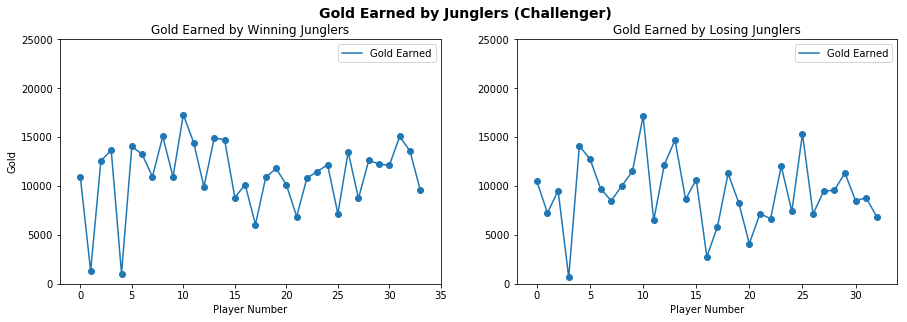

In [8]:
# Graph the Gold Earned by each Jungler

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,4.5)) 
goldVictory.plot(ax = ax[0]).scatter(goldVictory.index, goldVictory['Gold Earned'])
goldLoss.plot(ax = ax[1]).scatter(goldLoss.index, goldLoss['Gold Earned'])

ax[0].set_title("Gold Earned by Winning Junglers")
ax[1].set_title("Gold Earned by Losing Junglers")

ax[0].set_ylabel("Gold")

ax[0].set_ylim([0, 25000])
ax[1].set_ylim([0, 25000])

for var in ax:
    var.set_xlabel("Player Number")
    
fig.suptitle("Gold Earned by Junglers (Challenger)", fontsize = 14, fontweight = "bold")

In [9]:
# Concatenate both columns for easier comparison

goldDescribe = pd.concat([goldVictory.describe(), goldLoss.describe()], axis = 1)
goldDescribe.columns = ['Gold (Winning Junglers)', 'Gold (Losing Junglers)']
goldDescribe

,Gold (Winning Junglers),Gold (Losing Junglers)
count,34.000000,33.000000
mean,11137.735294,9294.151515
std,3571.650084,3498.989168
min,1050.000000,668.000000
25%,9972.250000,7167.000000
50%,11624.500000,9479.000000
75%,13544.250000,11326.000000
max,17280.000000,17142.000000


As expected, the Junglers who earned more Gold won more often. The more Gold a Jungler has, the stronger equipment he can buy to aid him in killing enemies and securing objectives. It seems that the majority of the winning Junglers' Gold earned fell between around 10000 to 15000 Gold. 

Note that the minimum values of Gold earned by Winning and Losing Junglers are significantly lower than their respective means. This can be attributed to the length of a game itself - if a game is an incredibly one-sided steamroll, a relatively small amount of Gold can be enough to press the advantage hard enough to end the game very quickly.

## 1b) First Team to Take Objectives

As previously mentioned, the purpose of League of Legends is to destroy the enemy's base. The main objectives in the game are Turrets, large defensive structures which stand between a team and the enemy's base. However, there are also two additional objectives: the Dragon and the Baron. Defeating the Dragon and Baron grants the team benefits such as increased power or sieging ability, making them invaluable for victory.

Let's analyze the correlation between being the first to take these three objectives and victory.

In [10]:
tv = turretVictory[list(turretVictory)[1]].value_counts()
dv = dragonVictory[list(dragonVictory)[1]].value_counts()
bv = baronVictory[list(baronVictory)[1]].value_counts()

display(tv)
display(dv)
display(bv)

True     27
False     5
N/A       2
Name: Victory, dtype: int64

True     21
False    10
N/A       3
Name: Victory, dtype: int64

True     17
N/A      14
False     3
Name: Victory, dtype: int64

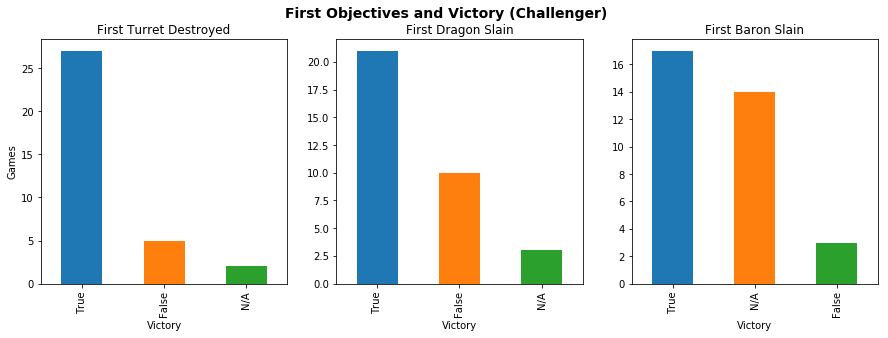

In [11]:
# A direct comparison of first objective and Victory

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4.5)) 
tv.plot(ax = ax[0], kind = 'bar')
dv.plot(ax = ax[1], kind = 'bar')
bv.plot(ax = ax[2], kind = 'bar')

ax[0].set_title("First Turret Destroyed")
ax[1].set_title("First Dragon Slain")
ax[2].set_title("First Baron Slain")

ax[0].set_ylabel("Games")

for var in ax:
    var.set_xlabel("Victory")

fig.suptitle("First Objectives and Victory (Challenger)", fontsize = 14, fontweight = "bold")

# There is a positive correlation between all three of these factors. 

Destroying the first tower not only indicates that a team's players have outmaneuvered and outplayed their opponents, but also rewards the destroying team a large sum of gold which can be used to purchase more powerful equipment to further press their lead. This can be seen in the above graph, where in **84.38% (27/32)** of games where the first tower was taken, a victory was secured.

Killing the first Dragon gives a small permanent boost in team power, ranging from increased sieging power to augmented movement speed. Benefits multiply after the first boost, so taking the first Dragon is important to start the multiplicative effect. However, while the boost is certainly beneficial, it varies and is determined by a random number generator, so it may not always fit what the team needs at the time. This explains the weakened correlation between the two, where victory was secured in only **67.74% (21/31)** of games where the first Dragon was slain.

Killing the first Baron grants massively augmented combat and sieging power. While the boost is only temporary, it is enough to cause significant damage to an enemy's base and team members and often end the game outright. This can be seen in the incredibly strong correlation between first Baron slain and victory, with **85% (17/20)** first Baron games resulting in victory.

Great. Now that we've seen team statistics, let's take a look at individual statistics.

## 1c) Jungler KDA

League of Legends is a team game, but naturally, the better a team's individual players are, the higher chance of victory being secured.

The statistic KDA, or Kills/Deaths/Assists, is the ratio of (Kills + Assists) / Deaths. Kills are highly beneficial because killing an opponent not only removes them from the game for a set amount of time, but also rewards Gold and experience. A player can capitalize on an opponent's death to take objectives, earn Gold, and take other useful actions unhindered by an opponent. Assists indicate that a player helped in killing an opponent, and reward slightly less Gold and experience. In contrast, deaths are a setback for players for the same reason - while dead, a player cannot take any actions to defend or attack objectives and gives Gold and experience to an opponent.

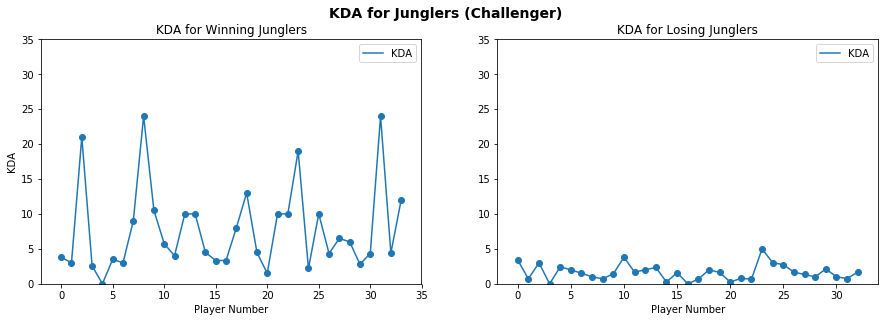

In [12]:
# Comparing winning Junglers' and losing Junglers' KDAs

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,4.5)) 

kdaVictory.plot(ax = ax[0]).scatter(x = kdaVictory.index, y = kdaVictory['KDA'])
kdaLoss.plot(ax = ax[1]).scatter(x = kdaLoss.index, y = kdaLoss['KDA'])

ax[0].set_title("KDA for Winning Junglers")
ax[1].set_title("KDA for Losing Junglers")

ax[0].set_ylabel("KDA")
ax[0].set_ylim([0, 35])
ax[1].set_ylim([0, 35])
for var in ax:
    var.set_xlabel("Player Number")
    
fig.suptitle("KDA for Junglers (Challenger)", fontsize = 14, fontweight = "bold")

In [13]:
# Deatiled statistics for this dataset

kdaDescribe = pd.concat([kdaVictory.describe(), kdaLoss.describe()], axis = 1)
kdaDescribe.columns = ['KDA (Winning Junglers)', 'KDA (Losing Junglers)']
kdaDescribe

,KDA (Winning Junglers),KDA (Losing Junglers)
count,34.000000,33.000000
mean,7.760434,1.640284
std,6.246951,1.138570
min,0.000000,0.000000
25%,3.375000,0.750000
50%,5.125000,1.600000
75%,10.000000,2.125000
max,24.000000,5.000000


There is a large disparity between the KDA of winning Junglers vs the KDA of losing Junglers. As seen in the games pulled from the Challenger Tier, even the worst-performing winning Jungler achieved a positive KDA ratio, showing that while Kills and Assists do not directly contribute to the destruction of the enemy base, they are certainly valuable and indirectly help a team achieve its end goal.

At a glance, it does seem like having a high KDA is correlated with victory. However, this doesn't necessarily mean that securing a high KDA will result in a victory. Let's take a closer look within this sample of games to check if having a higher KDA than the enemy Jungler results in victory. We will now directly compare opposing Junglers for every game and assess the outcome of the game:

In [14]:
# Concatenate both Junglers' columns for direct comparison of KDA

kdaCompare = pd.concat([kdaVictory['KDA'], kdaLoss['KDA']], axis = 1)
kdaCompare.columns = ['KDA (Winning Jungler)', 'KDA (Losing Jungler)']
display(kdaCompare)

,KDA (Winning Jungler),KDA (Losing Jungler)
0,3.800000,3.400000
1,3.000000,0.714286
2,21.000000,3.000000
3,2.571429,0.000000
4,0.000000,2.428571
5,3.500000,2.000000
6,3.000000,1.500000
7,9.000000,1.000000
8,24.000000,0.714286
9,10.500000,1.444444


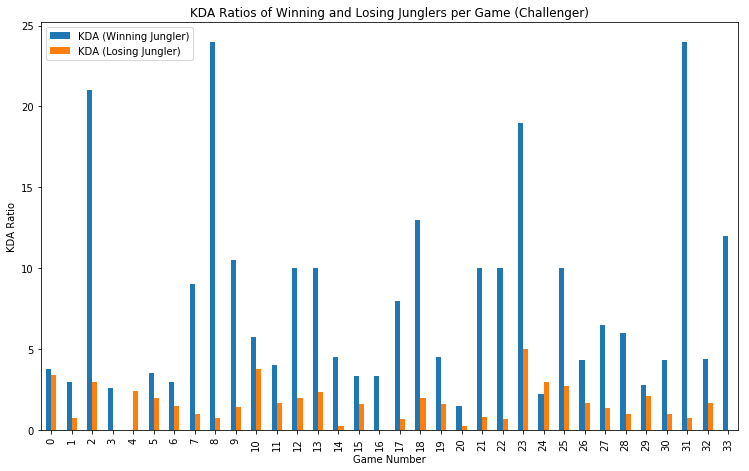

In [15]:
# Compare Junglers' KDAs and game results across all games

fig, ax = plt.subplots()
kdaCompare.plot(ax = ax, kind = 'bar', figsize = (12.5, 7.5))
ax.set_ylabel('KDA Ratio')
ax.set_xlabel('Game Number')
ax.set_title('KDA Ratios of Winning and Losing Junglers per Game (Challenger)')

In [16]:
# Directly compare and plot Higher KDA and Victory

higherKdaVictory = {'Higher KDA' : [], 'Victory' : []}
for index, row in kdaCompare.iterrows():
    winningJungler = row['KDA (Winning Jungler)']
    losingJungler = row['KDA (Losing Jungler)']
    if winningJungler > losingJungler:
        higherKdaVictory['Higher KDA'].append(True)
    else:
        higherKdaVictory['Higher KDA'].append(False)
    higherKdaVictory['Victory'].append(True)

higherKdaVictory = pd.DataFrame(higherKdaVictory)

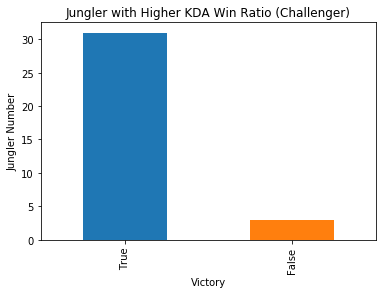

In [17]:
fig, ax = plt.subplots()
hkv = higherKdaVictory[list(higherKdaVictory)[0]].value_counts()
ax.set_title("Jungler with Higher KDA Win Ratio (Challenger)")
ax.set_ylabel("Jungler Number")
ax.set_xlabel("Victory")

hkv.plot(ax = ax, kind = 'bar')

As seen in the graph, it looks like KDA actually does matter as much as the original graph led on. In a whopping **31/34 (91.18%)** of the games, the Jungler with the higher KDA was able to secure victory, and in the other **3/34 (8.82%)**, the Jungler was unable to translate his high kill score into a victory. This small percentage of Junglers may be because these Junglers may have become too bloodthirsty, opting to kill the members of the enemy team instead of focusing on objectives such as Towers and Epic Monsters.

Ultimately, League of Legends is a game that is centered around destroying the enemy base. The Jungler's role is to create opportunities to do so by facilitating kills, but if he becomes complacent, focuses too much on inflating his score, or fails to capitalize on the kills he enables, a powerful Jungler can definitely still lose the game. On the other hand, if a Jungler fares poorly early on and is unable to facilitate kills, he may still be able to win by playing to destroy Towers and benefit his team.

In this case, it is unsurprising that nearly all high KDA Junglers are able to translate their high kill scores into Victories - these are the best players in the world, and understand very well that League of Legends is not an individual, kill-focused game.

Bringing the focus back onto objectives, let's take a look at how opposing Junglers fared in being team-based, objective-oriented players.

## 1d) Damage to Dragon and Baron

We already know that the first Dragon and Baron are correlated with victory. In theory, a Jungler's duty is to secure these powerful objectives for his team. Let's take a look at the total damage dealt to Dragons and Barons per each Jungler.

In [18]:
# Comparing Objective Damage between Winning and Losing Junglers

objectiveDamageCompare = pd.concat([objectiveDamageVictory['Damage to Objectives'], 
                                    objectiveDamageLoss['Damage to Objectives']], axis = 1)
objectiveDamageCompare.columns = ['Damage to Objectives (Winning Jungler)', 'Damage to Objectives (Losing Jungler)']
display(objectiveDamageCompare)

,Damage to Objectives (Winning Jungler),Damage to Objectives (Losing Jungler)
0,28648,5896.0
1,0,5556.0
2,18209,9749.0
3,12916,0.0
4,0,7451.0
5,26339,20261.0
6,18638,395.0
7,23579,1539.0
8,33848,16727.0
9,19420,10177.0


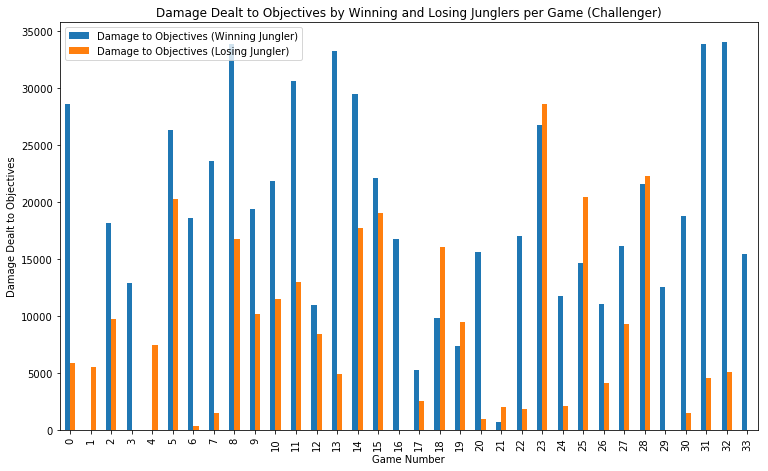

In [19]:
# Comparing Damage Dealt and Victory across all games

fig, ax = plt.subplots()
objectiveDamageCompare.plot(ax = ax, kind = 'bar', figsize = (12.5, 7.5))
ax.set_ylabel('Damage Dealt to Objectives')
ax.set_xlabel('Game Number')
ax.set_title('Damage Dealt to Objectives by Winning and Losing Junglers per Game (Challenger)')

In [20]:
# More direct visualization of high objective damage/Victory

higherObjectiveVictory = {'Higher Damage to Objectives' : [], 'Victory' : []}
for index, row in objectiveDamageCompare.iterrows():
    winningJungler = row['Damage to Objectives (Winning Jungler)']
    losingJungler = row['Damage to Objectives (Losing Jungler)']
    if winningJungler > losingJungler:
        higherObjectiveVictory['Higher Damage to Objectives'].append(True)
    else:
        higherObjectiveVictory['Higher Damage to Objectives'].append(False)
    higherObjectiveVictory['Victory'].append(True)

higherObjectiveVictory = pd.DataFrame(higherObjectiveVictory)

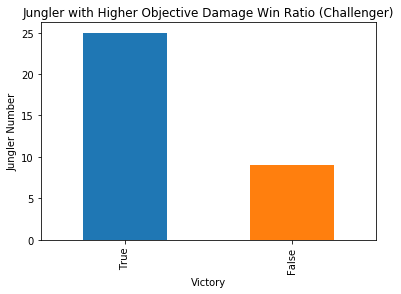

In [21]:
fig, ax = plt.subplots()
hov = higherObjectiveVictory[list(higherObjectiveVictory)[0]].value_counts()
ax.set_title("Jungler with Higher Objective Damage Win Ratio (Challenger)")
ax.set_ylabel("Jungler Number")
ax.set_xlabel("Victory")

hov.plot(ax = ax, kind = 'bar')

Very interesting. Despite the Jungler's duty being to kill these monsters for his team, outdamaging the enemy Jungler against the Baron or Dragon don't seem to carry as much weight as initially hypothesized. In only **73.52% (25/34)** of games where a Jungler outdamaged his counterpart did he manage to ultimately win the game.

This can be attributed to a couple of factors. One, which was mentioned beforehand, is that the benefits of the Dragon in particular do not have as much of an immediate impact on the game as Turrets or Barons do. The benefits are relatively small, take time to multiply and ramp up, and are random.

The other reason is that **the benefits Dragon and Baron go to the team that lands the killing blow.** In other words, if Blue Team's Jungler damages 95% of the Dragon's health bar and Red Team's Jungler finishes it off, the benefits go to the Red Team. A common scenario that occurs when attempting to secure Baron is that an enemy will attempt "steal" the benefits by landing the killing blow, turning a normally beneficial situation into a bad one.

All of this adds up to mean that the sum of damage itself towards Epic Monsters is not a clear indicator of Victory.

## 1e) Damage to Turrets

We saw in our previous analysis that the first Turret is quite impactful on the game's outcome. How about the Jungler's damage output towards the Turrets?

In [22]:
# Comparing Turret Damage between Junglers

turretDamageCompare = pd.concat([turretDamageVictory['Damage to Turrets'], 
                                    turretDamageLoss['Damage to Turrets']], axis = 1)
turretDamageCompare.columns = ['Damage to Turrets (Winning Jungler)', 'Damage to Turrets (Losing Jungler)']
display(turretDamageCompare)

,Damage to Turrets (Winning Jungler),Damage to Turrets (Losing Jungler)
0,2862,1696.0
1,0,0.0
2,3792,430.0
3,5850,0.0
4,0,0.0
5,4900,8084.0
6,3089,395.0
7,6825,0.0
8,6615,0.0
9,3118,1209.0


In [23]:
higherTurretVictory = {'Higher Damage to Turrets' : [], 'Victory' : []}
for index, row in turretDamageCompare.iterrows():
    winningJungler = row['Damage to Turrets (Winning Jungler)']
    losingJungler = row['Damage to Turrets (Losing Jungler)']
    if winningJungler > losingJungler:
        higherTurretVictory['Higher Damage to Turrets'].append(True)
    else:
        higherTurretVictory['Higher Damage to Turrets'].append(False)
    higherTurretVictory['Victory'].append(True)

higherTurretVictory = pd.DataFrame(higherTurretVictory)

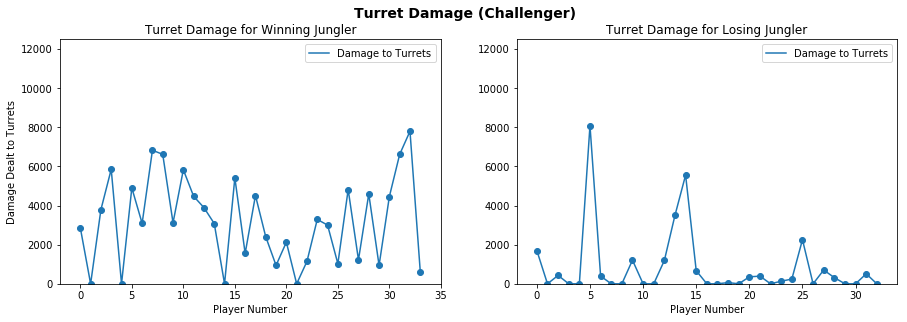

In [24]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,4.5)) 
turretDamageVictory.plot(ax = ax[0]).scatter(turretDamageVictory.index, turretDamageVictory['Damage to Turrets'])
turretDamageLoss.plot(ax = ax[1]).scatter(turretDamageLoss.index, turretDamageLoss['Damage to Turrets'])

ax[0].set_title("Turret Damage for Winning Jungler")
ax[1].set_title("Turret Damage for Losing Jungler")

ax[0].set_ylabel("Damage Dealt to Turrets")
ax[0].set_ylim([0, 12500])
ax[1].set_ylim([0, 12500])
for var in ax:
    var.set_xlabel("Player Number")
    
fig.suptitle("Turret Damage (Challenger)", fontsize = 14, fontweight = "bold")

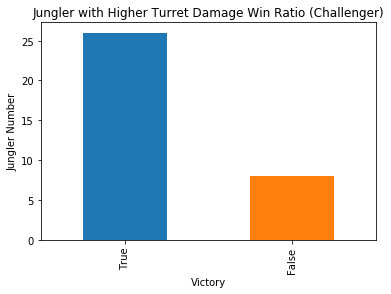

In [25]:
fig, ax = plt.subplots()
htv = higherTurretVictory[list(higherTurretVictory)[0]].value_counts()
ax.set_title("Jungler with Higher Turret Damage Win Ratio (Challenger)")
ax.set_ylabel("Jungler Number")
ax.set_xlabel("Victory")

htv.plot(ax = ax, kind = 'bar')

It seems that Turret Damage is more strongly correlated with Victory than with Epic Monsters, with a **76.47% (26/34)** rate of Victory. This is because Turrets a large sum of Gold and other advantages. For example, killing an enemy champion yields 300 Gold to the killer, with 50% of that number being split across teammates who assisted. For the average kill, this means that 450 Gold will be granted to the team. Killing an Epic Monster will grant varying benefits.

However, destroying Turrets yields far greater benefits. The destroyer(s) of the tower will receive 250 Gold, but all five members will also receive 100 Gold individually for 500 + 250 = 750 Gold. In addition, if that tower was the first to be destroyed, an additional 300 Gold will be granted to the destroyer(s). This means that while a kill can yield 450 Gold to a team, destroying a Tower can grant up to 1050 Gold, as well as provide a large strategic advantage over the opposing team. Furthermore, Towers closer to the Base and Nexus will give higher base Gold when destroyed.

It's no wonder why League of Legends is a turret-focused team game.

## 2) Silver Tier

We've managed to discover that Turrets and KDA are the most important factors in deciding a game, while damage to objectives is not nearly as important. However, it's important to remember that these are the best players in the world.

Let's now take a glance at the median players of League of Legends to see if the same trends hold true. The Silver Tier is where the majority of games' player population falls, with the top 50% of the playerbase being Silver rank. While these players may have some grasp of the game and are not in the bottom Tier, Bronze, they still lack fundamental skills and understanding of the game that prevents them from being any better than average.

While the Riot API does not provide direct access to any tiers beyond Challenger, if we know the name of a player, we can still scrape all the players in that person's league.

In [26]:
# Very similar function as the one used above, modified to use a player's name to scrape data from his Tier.

def getLeague(summonerName, turretVictory, dragonVictory, baronVictory, kdaVictory, kdaLoss, goldVictory,
         goldLoss, turretDamageVictory, turretDamageLoss, objectiveDamageVictory, objectiveDamageLoss):
    
    league = cass.get_summoner(name = summonerName)
    leaguePlayers = []
    
    for i in league.leagues:
        for player in i.entries:
            leaguePlayers.append(player)
    
    count = 1
    for player in range(0, 35):
        currentMatch = leaguePlayers[player].summoner.match_history[random.randint(0,10)]
        if currentMatch.mode.name == 'classic':
            print("Rank", count, "player is", leaguePlayers[player].summoner.name)
            if count == 1: # Display the first match
                display(individualStats(currentMatch.participants))
            firstObjectiveStats(currentMatch, turretVictory, dragonVictory, baronVictory) # Correlation between first objectives and win
            individualWinStats(currentMatch, kdaVictory, kdaLoss, objectiveDamageVictory, objectiveDamageLoss, turretDamageVictory, turretDamageLoss, goldVictory, goldLoss)
        count += 1
    

In [27]:
# Dictionaries for data manipulation

turretVictory = {'First Turret Taken':[],'Victory':[]}
dragonVictory = {'First Dragon Taken':[],'Victory':[]}
baronVictory = {'First Baron Taken':[],'Victory':[]}

kdaVictory = {"KDA":[],'Victory':[]}
kdaLoss = {"KDA":[],'Victory':[]}

goldVictory = {"Gold Earned":[],"Victory":[]}
goldLoss = {"Gold Earned":[],"Victory":[]}

turretDamageVictory = {'Damage to Turrets':[], 'Victory':[]}
turretDamageLoss = {'Damage to Turrets':[], 'Victory':[]}

objectiveDamageVictory = {'Damage to Objectives':[], 'Victory':[]}
objectiveDamageLoss = {'Damage to Objectives':[], 'Victory':[]}

# We will use the Silver player "Worst Dancer NA" as reference.

getLeague("Worst Dancer NA", turretVictory, dragonVictory, baronVictory, kdaVictory, kdaLoss, goldVictory,
         goldLoss, turretDamageVictory, turretDamageLoss, objectiveDamageVictory, objectiveDamageLoss)

Making call: https://na1.api.riotgames.com/lol/summoner/v3/summoners/by-name/WorstDancerNA
Making call: https://na1.api.riotgames.com/lol/league/v3/positions/by-summoner/44849010
Making call: https://na1.api.riotgames.com/lol/league/v3/leagues/fa750310-fef3-11e7-919f-c81f66cf2333
Making call: https://na1.api.riotgames.com/lol/summoner/v3/summoners/49254918
Making call: https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/212248470?beginIndex=0&endIndex=100
Making call: https://na1.api.riotgames.com/lol/match/v3/matches/2778175120
Rank 1 player is Brazzers com


/Users/jonathanwang/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:9: DeprecationWarning: generator 'SearchableLazyList.__iter__' raised StopIteration


,Champion,Jungler,Kills,Deaths,Assists,KDA,Towers Destroyed,Damage to Objectives,Team
Player,,,,,,,,,
KrombopulosMikel,Zilean,False,2,7,10,1.714286,0,5803,blue
Legendary Morty,Ezreal,False,5,5,3,1.600000,0,1929,blue
hmu for dabs,Ekko,False,6,9,4,1.111111,0,0,blue
ohh ok,Maokai,False,3,5,4,1.400000,0,384,blue
Brazzers com,Aatrox,True,6,8,5,1.375000,0,18223,blue
jiiide,Zyra,False,8,4,7,3.750000,1,3358,red
Apollo4910,Miss Fortune,False,2,5,12,2.800000,0,5543,red
dragon3eggroll,Master Yi,True,12,3,6,6.000000,2,15028,red
Winnings,Vladimir,False,7,4,9,4.000000,0,1601,red


/Users/jonathanwang/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: generator 'SearchableLazyList.__iter__' raised StopIteration
  from ipykernel import kernelapp as app


Making call: https://na1.api.riotgames.com/lol/summoner/v3/summoners/73630463
Making call: https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/232093495?beginIndex=0&endIndex=100
Making call: https://na1.api.riotgames.com/lol/match/v3/matches/2782345235
Rank 2 player is PNWes
Making call: https://na1.api.riotgames.com/lol/summoner/v3/summoners/27783918
Making call: https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/42268799?beginIndex=0&endIndex=100
Making call: https://na1.api.riotgames.com/lol/match/v3/matches/2746688600
Rank 3 player is Dispenger
Making call: https://ddragon.leagueoflegends.com/cdn/8.6.1/data/en_US/summoner.json
Making call: https://na1.api.riotgames.com/lol/summoner/v3/summoners/59138578
Making call: https://na1.api.riotgames.com/lol/match/v3/matchlists/by-account/220444149?beginIndex=0&endIndex=100
Making call: https://na1.api.riotgames.com/lol/match/v3/matches/2780727305
Rank 4 player is 3ShotWilliams
Making call: https://na1.api.riotga

In [28]:
# Convert into DataFrames for data manipulation

turretVictory = pd.DataFrame(turretVictory)
dragonVictory = pd.DataFrame(dragonVictory)
baronVictory = pd.DataFrame(baronVictory)

kdaVictory = pd.DataFrame(kdaVictory)
kdaLoss = pd.DataFrame(kdaLoss)

objectiveDamageVictory = pd.DataFrame(objectiveDamageVictory)
objectiveDamageLoss = pd.DataFrame(objectiveDamageLoss)

turretDamageVictory = pd.DataFrame(turretDamageVictory)
turretDamageLoss = pd.DataFrame(turretDamageLoss)

goldVictory = pd.DataFrame(goldVictory)
goldLoss = pd.DataFrame(goldLoss)

## 2a) First Team to Take Objectives

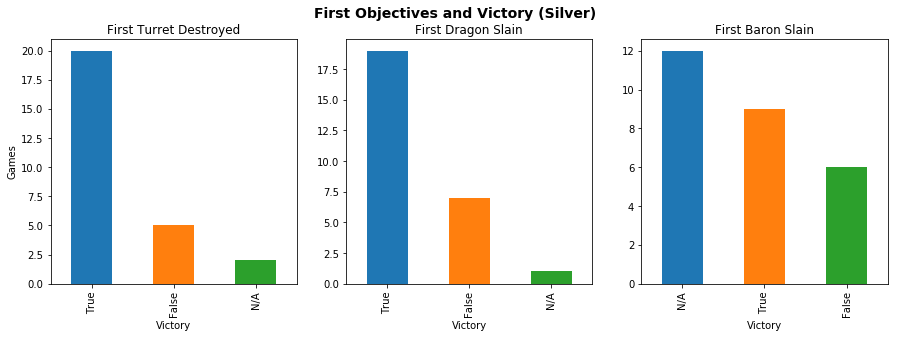

In [29]:
tv = turretVictory[list(turretVictory)[1]].value_counts()
dv = dragonVictory[list(dragonVictory)[1]].value_counts()
bv = baronVictory[list(baronVictory)[1]].value_counts()

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (15,4.5)) 
tv.plot(ax = ax[0], kind = 'bar')
dv.plot(ax = ax[1], kind = 'bar')
bv.plot(ax = ax[2], kind = 'bar')

ax[0].set_title("First Turret Destroyed")
ax[1].set_title("First Dragon Slain")
ax[2].set_title("First Baron Slain")

ax[0].set_ylabel("Games")

for var in ax:
    var.set_xlabel("Victory")

fig.suptitle("First Objectives and Victory (Silver)", fontsize = 14, fontweight = "bold")

Interesting. We see for the most part that the trends are the same in Silver as they are in Challenger - the First Turret is a strong indicator of who will win the game, and the First Dragon has a slightly weaker correlation.

However, the First Baron differs greatly from Challenger Players. In most games, the First Baron is not even killed, and in the ones that it is, only **60% (9/15)** games result in Victory. This may be because Silver players generally are less skilled and focused on objectives as much as higher-level players are. Without a more tangible advantage like a destroyed Turret, Silver players may not understand how to use the Baron's benefits to destroy the enemy base, leading to more potential for comebacks.

## 2b) Jungler KDA

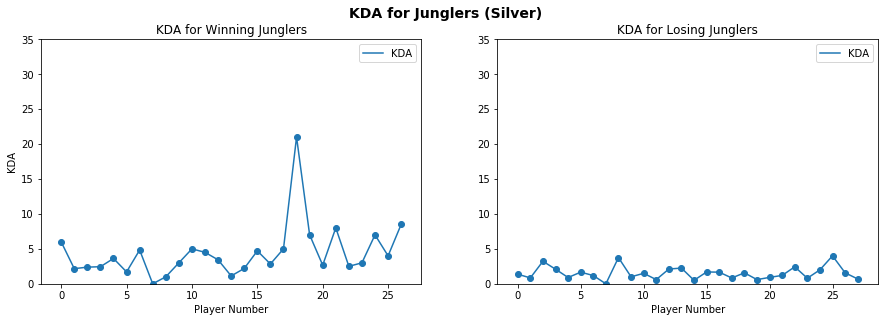

In [30]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,4.5)) 

kdaVictory.plot(ax = ax[0]).scatter(x = kdaVictory.index, y = kdaVictory['KDA'])
kdaLoss.plot(ax = ax[1]).scatter(x = kdaLoss.index, y = kdaLoss['KDA'])

ax[0].set_title("KDA for Winning Junglers")
ax[1].set_title("KDA for Losing Junglers")

ax[0].set_ylabel("KDA")
ax[0].set_ylim([0, 35])
ax[1].set_ylim([0, 35])
for var in ax:
    var.set_xlabel("Player Number")
    
fig.suptitle("KDA for Junglers (Silver)", fontsize = 14, fontweight = "bold")

In [31]:
kdaDescribe = pd.concat([kdaVictory.describe(), kdaLoss.describe()], axis = 1)
kdaDescribe.columns = ['KDA (Winning Junglers)', 'KDA (Losing Junglers)']
kdaDescribe

,KDA (Winning Junglers),KDA (Losing Junglers)
count,27.000000,28.000000
mean,4.430441,1.534377
std,3.940637,0.958246
min,0.000000,0.000000
25%,2.414530,0.839912
50%,3.428571,1.437500
75%,5.000000,2.022727
max,21.000000,4.000000


In [32]:
kdaCompare = pd.concat([kdaVictory['KDA'], kdaLoss['KDA']], axis = 1)
kdaCompare.columns = ['KDA (Winning Jungler)', 'KDA (Losing Jungler)']
display(kdaCompare)

,KDA (Winning Jungler),KDA (Losing Jungler)
0,6.000000,1.375000
1,2.166667,0.842105
2,2.384615,3.222222
3,2.444444,2.090909
4,3.625000,0.900000
5,1.700000,1.666667
6,4.833333,1.181818
7,0.000000,0.000000
8,1.000000,3.750000
9,3.000000,1.000000


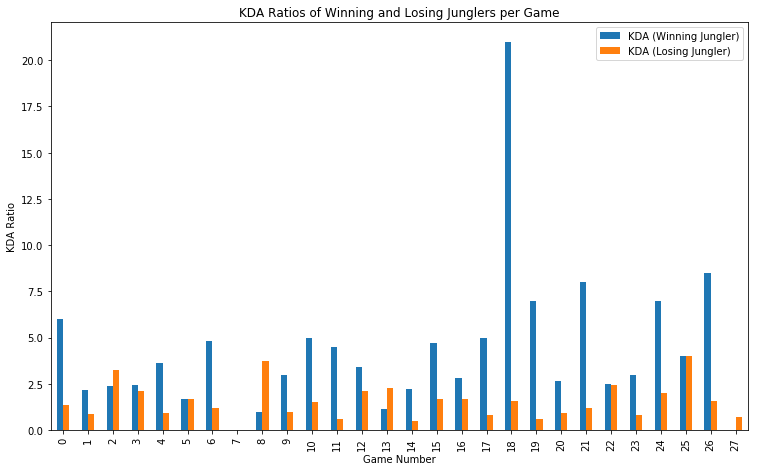

In [33]:
fig, ax = plt.subplots()
kdaCompare.plot(ax = ax, kind = 'bar', figsize = (12.5, 7.5))
ax.set_ylabel('KDA Ratio')
ax.set_xlabel('Game Number')
ax.set_title('KDA Ratios of Winning and Losing Junglers per Game')

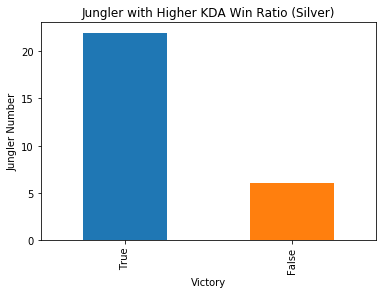

In [34]:
higherKdaVictory = {'Higher KDA' : [], 'Victory' : []}
for index, row in kdaCompare.iterrows():
    winningJungler = row['KDA (Winning Jungler)']
    losingJungler = row['KDA (Losing Jungler)']
    if winningJungler > losingJungler:
        higherKdaVictory['Higher KDA'].append(True)
    else:
        higherKdaVictory['Higher KDA'].append(False)
    higherKdaVictory['Victory'].append(True)

higherKdaVictory = pd.DataFrame(higherKdaVictory)

fig, ax = plt.subplots()
hkv = higherKdaVictory[list(higherKdaVictory)[0]].value_counts()
ax.set_title("Jungler with Higher KDA Win Ratio (Silver)")
ax.set_ylabel("Jungler Number")
ax.set_xlabel("Victory")

hkv.plot(ax = ax, kind = 'bar')

We mentioned previously that Challenger players understand how to convert their kills into Victory for their team, and that lower-level players may not; this is visualized quite clearly in the above graph. Average players may get caught up in their bloodlust for other players and forget their purpose in-game, or simply fail to capitalize on the advantages that they get, resulting in Defeats even when they are stronger than the opposing Jungler.

## 2c) Damage to Dragon and Baron

,Damage to Objectives (Winning Jungler),Damage to Objectives (Losing Jungler)
0,15028.0,18223
1,14228.0,27613
2,20027.0,15588
3,36902.0,5726
4,32395.0,10316
5,35411.0,2001
6,19682.0,28682
7,0.0,0
8,18665.0,13890
9,1687.0,4415


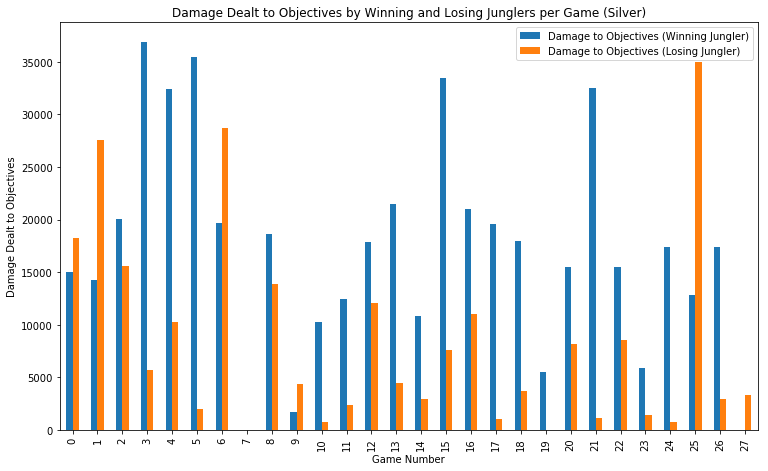

In [35]:
objectiveDamageCompare = pd.concat([objectiveDamageVictory['Damage to Objectives'], 
                                    objectiveDamageLoss['Damage to Objectives']], axis = 1)
objectiveDamageCompare.columns = ['Damage to Objectives (Winning Jungler)', 'Damage to Objectives (Losing Jungler)']
display(objectiveDamageCompare)

fig, ax = plt.subplots()
objectiveDamageCompare.plot(ax = ax, kind = 'bar', figsize = (12.5, 7.5))
ax.set_ylabel('Damage Dealt to Objectives')
ax.set_xlabel('Game Number')
ax.set_title('Damage Dealt to Objectives by Winning and Losing Junglers per Game (Silver)')

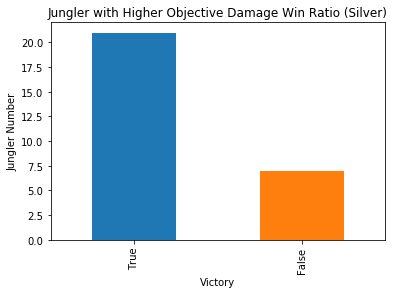

In [36]:
higherObjectiveVictory = {'Higher Damage to Objectives' : [], 'Victory' : []}
for index, row in objectiveDamageCompare.iterrows():
    winningJungler = row['Damage to Objectives (Winning Jungler)']
    losingJungler = row['Damage to Objectives (Losing Jungler)']
    if winningJungler > losingJungler:
        higherObjectiveVictory['Higher Damage to Objectives'].append(True)
    else:
        higherObjectiveVictory['Higher Damage to Objectives'].append(False)
    higherObjectiveVictory['Victory'].append(True)

higherObjectiveVictory = pd.DataFrame(higherObjectiveVictory)

fig, ax = plt.subplots()
hov = higherObjectiveVictory[list(higherObjectiveVictory)[0]].value_counts()
ax.set_title("Jungler with Higher Objective Damage Win Ratio (Silver)")
ax.set_ylabel("Jungler Number")
ax.set_xlabel("Victory")

hov.plot(ax = ax, kind = 'bar')

Objective Damage in Silver seems to have the same trend as in Challenger. **75% (21/28)** of Junglers who outdamaged their counterparts in Objective Damage secured Victory, so there is definitely still a strong correlation.

## 2d) Damage to Turrets

In [37]:
turretDamageCompare = pd.concat([turretDamageVictory['Damage to Turrets'], 
                                    turretDamageLoss['Damage to Turrets']], axis = 1)
turretDamageCompare.columns = ['Damage to Turrets (Winning Jungler)', 'Damage to Turrets (Losing Jungler)']
display(turretDamageCompare)

,Damage to Turrets (Winning Jungler),Damage to Turrets (Losing Jungler)
0,4207.0,0
1,5703.0,6606
2,8644.0,886
3,6300.0,4107
4,1421.0,4806
5,1976.0,0
6,4210.0,0
7,0.0,0
8,685.0,0
9,158.0,0


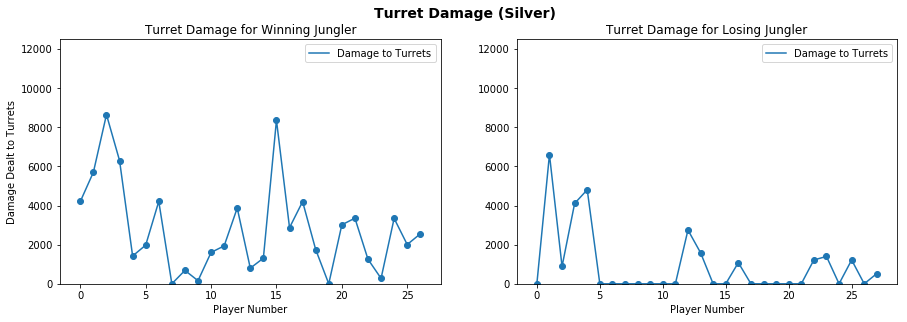

In [38]:
higherTurretVictory = {'Higher Damage to Turrets' : [], 'Victory' : []}
for index, row in turretDamageCompare.iterrows():
    winningJungler = row['Damage to Turrets (Winning Jungler)']
    losingJungler = row['Damage to Turrets (Losing Jungler)']
    if winningJungler > losingJungler:
        higherTurretVictory['Higher Damage to Turrets'].append(True)
    else:
        higherTurretVictory['Higher Damage to Turrets'].append(False)
    higherTurretVictory['Victory'].append(True)

higherTurretVictory = pd.DataFrame(higherTurretVictory)

fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,4.5)) 
turretDamageVictory.plot(ax = ax[0]).scatter(turretDamageVictory.index, turretDamageVictory['Damage to Turrets'])
turretDamageLoss.plot(ax = ax[1]).scatter(turretDamageLoss.index, turretDamageLoss['Damage to Turrets'])

ax[0].set_title("Turret Damage for Winning Jungler")
ax[1].set_title("Turret Damage for Losing Jungler")

ax[0].set_ylabel("Damage Dealt to Turrets")
ax[0].set_ylim([0, 12500])
ax[1].set_ylim([0, 12500])
for var in ax:
    var.set_xlabel("Player Number")
    
fig.suptitle("Turret Damage (Silver)", fontsize = 14, fontweight = "bold")

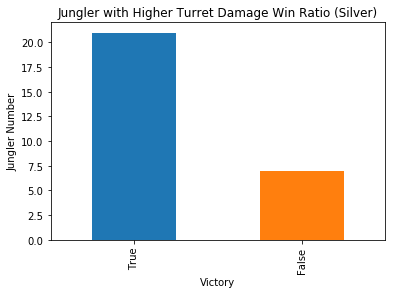

In [39]:
fig, ax = plt.subplots()
htv = higherTurretVictory[list(higherTurretVictory)[0]].value_counts()
ax.set_title("Jungler with Higher Turret Damage Win Ratio (Silver)")
ax.set_ylabel("Jungler Number")
ax.set_xlabel("Victory")

htv.plot(ax = ax, kind = 'bar')

And interestingly enough, **75% (21/28)** of Junglers who scored higher Turret Damage than their counterparts also went on to win the game. This is comparable to the Challenger Tier's **76.47% (26/34)**. I initially assumed that average players would be unable to convert their Turrets into Victories, but it seems that Turrets are far more tangible advantages than Epic Monsters.

## Conclusion

After analyzing the players in both Tiers, several trends can be seen.

In the Challenger Tier, KDA is the key to victory. Being directly superior to your opponents in skill and being able to kill them before they can kill you is important at every level, but especially critical at the top level. Players are far more likely to translate their high kill score into huge objective advantages - Turrets, Epic Monsters, and eventually base destruction all stem from being able to kill your opponents and take objectives unhindered. Junglers, especially, can use the Gold earned from kills to "snowball" out of control, buying incredibly powerful equipment and killing opponents and securing objectives, as seen by the very strong correlation between Gold and victory.

One aspect that ended up not being as important as I initially believed was the first Dragon. There was only a weak correlation between the first Dragon secured and victory - because of the randomness and long ramp time, nearly half of the Challenger Junglers lost after securing the first Dragon.

In the Silver Tier, where most average players reside, KDA was not nearly as inducive to victory as it was in Challenger. This can be chalked up to the fact that average players are simply not as good as top players at capitalizing on advantages, and more liable to "throw" their leads. Because of this inability to capitalize, there was also only a weak correlation between the first Baron secured and victory, as Silver players would likely not understand how to best abuse the benefits of the Baron.